In [577]:
import sys

sys.path.append(
    "C:\\Users\\Wyss User\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages"
)

import biolib
import gzip
import math
import os
import requests
import pathlib
import tspex

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xml.etree.ElementTree as ET

from io import StringIO
from IPython.display import Image
from matplotlib_venn import venn2
from matplotlib_venn import venn3
from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import mannwhitneyu
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [578]:
ASSAY_LIST_PATH = "assay-list-olink-explore-3072.xlsx"
BRAIN_RNA_SEQ_PATH = "brain_rna_seq.csv"
HGNC_IDS = (
    "https://ftp.ebi.ac.uk/pub/databases/genenames/hgnc/tsv/hgnc_complete_set.txt"
)
PLATE_LAYOUT_PATH = "Plate Layout.xlsx"
RAW_DATA_FILE = "LCSET_28343_10-4-2023_EXTENDED_NPX_2023-10-20.csv"
UNIPROT_TO_FASTA_PATH = "uniprotkb_proteome_UP000005640_2023_11_20.fasta.gz"

In [579]:
assays = pd.read_excel(ASSAY_LIST_PATH)


# Map UniProt IDs to the corresponding FASTA sequences
def parse_gz_file(file_path):
    protein_dict = {}
    current_uniprot_id = None
    current_sequence = ""
    with gzip.open(file_path, "rt") as f:
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                if current_uniprot_id is not None:
                    protein_dict[current_uniprot_id] = current_sequence
                    current_sequence = ""
                if "|" in line:
                    current_uniprot_id = line.split("|")[1].strip()
                else:
                    print(f"Skipping line without expected format: {line}")
                    current_uniprot_id = None
            else:
                current_sequence += line
        if current_uniprot_id is not None:
            protein_dict[current_uniprot_id] = current_sequence
    return protein_dict


fasta_sequences = parse_gz_file(UNIPROT_TO_FASTA_PATH)

assays["Sequence"] = assays["UniProt ID"].map(lambda x: fasta_sequences.get(x, "N/A"))

In [580]:
def tmhmm_localization(assays, output_directory):
    deeptmhmm = biolib.load("DTU/DeepTMHMM")
    with open("query.fasta", "w") as fasta_file:
        for _, row in assays.iterrows():
            fasta_line = f">{row['UniProt ID']}\n{row['Sequence']}\n"
            fasta_file.write(fasta_line)
        deeptmhmm_job = deeptmhmm.cli(args="--fasta query.fasta", machine="local")
        deeptmhmm_job.save_files(output_directory)


def identify_localization(assays, region, output_directory="olink_output"):
    """
    Parameters
    ----------
    assays : pandas.DataFrame
        DataFrame with columns called 'UniProt ID' and 'Sequence'
    region : {'TMhelix', 'inside', 'outside', 'internal'}
        Subcellular region requested. Options:
          - 'TMhelix': transmembrane proteins
          - 'inside': at least some of the protein is inside the cell/EV
          - 'outside': at least some of the protein is outside the cell/EV
          - 'internal': the protein is only found inside the cell, no transmembrane or outside domains
          - 'external': the protein is only found outside the cell, no transmembrane or inside domains
    """
    output_directory_path = pathlib.Path(output_directory)
    if not os.path.exists(output_directory_path):
        os.makedirs(output_directory_path)
    # os.chdir(output_directory)
    if not os.path.exists(output_directory_path / "TMRs.gff3"):
        tmhmm_localization(assays, output_directory_path)
    localization_df = pd.read_csv(
        output_directory_path / "TMRs.gff3",
        sep="\t",
        comment="#",
        names=[
            "uniprot_id",
            "region_location",
            "region_start",
            "region_end",
            0,
            1,
            2,
            3,
        ],
    )
    localization_df = localization_df[localization_df["uniprot_id"] != "//"].dropna(
        axis=1
    )
    get_regional_uniprots = lambda region: set(
        localization_df[localization_df["region_location"] == region]["uniprot_id"]
    )
    if region == "internal":
        tm_uniprots = get_regional_uniprots("TMhelix")
        outside_uniprots = get_regional_uniprots("outside")
        inside_uniprots = get_regional_uniprots("inside")
        return inside_uniprots - tm_uniprots - outside_uniprots
    if region == "external":
        tm_uniprots = get_regional_uniprots("TMhelix")
        outside_uniprots = get_regional_uniprots("outside")
        inside_uniprots = get_regional_uniprots("inside")
        return outside_uniprots - inside_uniprots - tm_uniprots
    else:
        return get_regional_uniprots(region)


tm_targets = identify_localization(assays, "TMhelix")
internal_targets = identify_localization(assays, "internal")
external_targets = identify_localization(assays, "external")

In [581]:
brain_rna_seq = pd.read_csv(BRAIN_RNA_SEQ_PATH)

hgnc_uniprot_mapping_data = pd.read_csv(
    (StringIO(requests.get(HGNC_IDS).text)),
    sep="\t",
    usecols=["hgnc_id", "uniprot_ids"],
)
brain_rna_seq = pd.merge(
    brain_rna_seq,
    hgnc_uniprot_mapping_data,
    left_on="id",
    right_on="hgnc_id",
    how="inner",
)
brain_rna_seq.dropna(subset=["uniprot_ids"], inplace=True)
brain_rna_seq.drop_duplicates(subset=["uniprot_ids"], inplace=True)

In [582]:
def calculate_mean(df):
    return df.assign(Mean=df.mean(axis=1, numeric_only=True))


def mean_cell_type(brain_rna_seq_data, cell_type):
    """
    Returns only the mean of the data for the specified cell type, as well as the UniProt ID information in an additional column
    Parameters
    ----------
    brain_rna_seq_data : pandas.DataFrame
        Dataframe with a column called "uniprot_ids" (contains UniProt ID), and other columns containing cell-type specific Brain RNA Seq data
    cell_type : {'fetal', 'mature', 'endothelial', 'microglia', 'oligodendrocyte', 'neuron'}
        Cell type of interest requested. Options:
         - 'astrocyte': mature astrocytes
         - 'endothelial': endothelial cells
         - 'microglia': microglia cells
         - 'oligodendrocyte': oligodendrocytes
         - 'neuron': neurons
    """
    if cell_type == "microglia":
        microglia_df = calculate_mean(
            brain_rna_seq_data[
                brain_rna_seq_data.filter(like="microglla").columns.append(
                    pd.Index(["uniprot_ids"])
                )
            ]
        )[["uniprot_ids", "Mean"]]
        return microglia_df.rename(
            columns={"uniprot_ids": "uniprot_ids", "Mean": "microglia"}
        )
    if cell_type == "astrocyte":
        astrocyte_df = calculate_mean(
            brain_rna_seq_data[
                brain_rna_seq_data.filter(like="mature").columns.append(
                    pd.Index(["uniprot_ids"])
                )
            ]
        )[["uniprot_ids", "Mean"]]
        return astrocyte_df.rename(
            columns={"uniprot_ids": "uniprot_ids", "Mean": "astrocyte"}
        )
    else:
        cell_type_df = calculate_mean(
            brain_rna_seq_data[
                brain_rna_seq_data.filter(like=cell_type).columns.append(
                    pd.Index(["uniprot_ids"])
                )
            ]
        )[["uniprot_ids", "Mean"]]
        return cell_type_df.rename(
            columns={"uniprot_ids": "uniprot_ids", "Mean": cell_type}
        )


def cell_type_enrichment(
    brain_rna_seq_data,
    cell_type,
    indiv_specificity_metric,
    indiv_specificity_cutoff,
    general_specificity_metric="none",
    general_specificity_cutoff="none",
):
    """
    Parameters
    ----------
    brain_rna_seq_data : pandas.DataFrame
        Dataframe with a column called "uniprot_ids" (contains UniProt ID), and other columns containing cell-type specific Brain RNA Seq data for the cell types listed under cell_type
    cell_type : {'fetal', 'mature', 'endothelial', 'microglia', 'oligodendrocyte', 'neuron'}
        Cell type of interest requested. Options:
         - 'astrocyte': mature astrocytes
         - 'endothelial': endothelial cells
         - 'microglia': microglia cells
         - 'oligodendrocyte': oligodendrocytes
         - 'neuron': neurons
    general_specificity_metric : {
        'tau',
        'counts',
        'gini',
        'simpson',
        'shannon_specifity',
        'roku_specificity',
        'spm_dpm',
        'js_specificity_dpm',
    }
        Primary metric of determining cell-type specificity requested. Options:
        - 'tau': tau score
        - 'counts': counts
        - 'gini': gini coefficient
        - 'simpson': simpson index
        - 'shannon_specificity': shannon entropy specificity (HS)
        - 'roku_specificity': ROKU specificity
        - 'spm_dpm': specificity measure dispersion (SPM DPM)
        - 'js_specificity_dpm': jensen-shannon specificity dispersion (JSS DPM)
        - 'none': default, no general specificity metric requested
    indiv_specificity_metric: {
        'tsi',
        'zscore',
        'spm',
        'js_specificity'
    }
        Secondary metric of determining cell type specificity requested. Options:
        - 'tsi': tissue specificity index
        - 'z-score': z-score
        - 'spm': specificity measure
        - 'js_specificity': jensen-shannon specificity
    general_specificity_cutoff : numeric
        Numeric value representing the minimum value of the first enrichment cutoff.
        Default = none
    indiv_specificity_cutoff : numeric
        Numeric value representing the minimum value of the second enrichment cutoff.
    """
    astrocytes = mean_cell_type(brain_rna_seq, "astrocyte")
    endothelial = mean_cell_type(brain_rna_seq, "endothelial")
    microglia = mean_cell_type(brain_rna_seq, "microglia")
    oligodendrocytes = mean_cell_type(brain_rna_seq, "oligodendrocyte")
    neurons = mean_cell_type(brain_rna_seq, "neuron")

    all_cell_types = pd.merge(
        pd.merge(
            pd.merge(
                pd.merge(astrocytes, endothelial, on="uniprot_ids"),
                microglia,
                on="uniprot_ids",
            ),
            oligodendrocytes,
            on="uniprot_ids",
        ),
        neurons,
        on="uniprot_ids",
    )
    all_cell_types.set_index("uniprot_ids", inplace=True)

    expression_data = all_cell_types.loc[
        :, ["endothelial", "astrocyte", "microglia", "neuron", "oligodendrocyte"]
    ]
    expression_data = expression_data.loc[(expression_data > 0).any(axis=1)]

    if general_specificity_metric == "none":
        tso_indiv = tspex.TissueSpecificity(
            expression_data, indiv_specificity_metric, log=True
        )
    else:
        tso_gen = tspex.TissueSpecificity(
            expression_data, general_specificity_metric, log=True
        )
        tso_gen_df = pd.DataFrame(
            tso_gen.tissue_specificity, columns=["general_specificity_metric"]
        )
        tso_gen_filtered = list(
            tso_gen_df[
                tso_gen_df["general_specificity_metric"] > general_specificity_cutoff
            ].index
        )
        tso_gen_filtered_df = expression_data.loc[tso_gen_filtered]

        tso_indiv = tspex.TissueSpecificity(
            tso_gen_filtered_df, indiv_specificity_metric, log=True
        )

    tso_indiv_df = pd.DataFrame(
        tso_indiv.tissue_specificity,
        columns=["endothelial", "astrocyte", "microglia", "neuron", "oligodendrocyte"],
    )
    cell_type_uniprot_ids = tso_indiv_df[
        tso_indiv_df[cell_type] > indiv_specificity_cutoff
    ].index.tolist()
    return cell_type_uniprot_ids


astrocyte_uniprot_ids = cell_type_enrichment(
    brain_rna_seq, "astrocyte", "zscore", 0.45, "tau", 0.7
)
microglia_uniprot_ids = cell_type_enrichment(
    brain_rna_seq, "microglia", "zscore", 0.45, "tau", 0.7
)
oligodendrocyte_uniprot_ids = cell_type_enrichment(
    brain_rna_seq, "oligodendrocyte", "zscore", 0.45, "tau", 0.7
)
neuron_uniprot_ids = cell_type_enrichment(
    brain_rna_seq, "neuron", "zscore", 0.45, "tau", 0.7
)

In [583]:
UNIMPORTANT_COLUMNS = [
    "Index",
    "OlinkID",
    "Panel_Lot_Nr",
    "PlateID",
    "WellID",
    "Normalization",
    "Processing_StartDate",
    "Processing_EndDate",
    "AnalyzerID",
    "ExploreVersion",
]

PANELS = [
    "Cardiometabolic",
    "Cardiometabolic_II",
    "Inflammation",
    "Inflammation_II",
    "Neurology",
    "Neurology_II",
    "Oncology",
    "Oncology_II",
]

# Clean up the raw OLINK data file and map the sample locations to their barcodes
plate_layout = pd.read_excel(PLATE_LAYOUT_PATH, index_col=0)
raw_data = pd.read_csv(RAW_DATA_FILE, sep=";")
raw_data = raw_data.drop(UNIMPORTANT_COLUMNS, axis=1)

data = pd.merge(raw_data, plate_layout, how="left", on="SampleID")

# Normalize the data according to plate negative controls
ctrl_dict = {}
for panel in PANELS:
    df = data[(data["Panel"] == panel)]
    plate_ctrl = df[
        (df["Sample_Type"] == "PLATE_CONTROL")
        & (df["Assay"] == "Amplification control 1")
    ]["NPX"].median()
    ctrl_dict[panel] = plate_ctrl
data["Delta"] = data.apply(
    lambda row: row["NPX"] - ctrl_dict[row["Panel"]],
    axis=1,
)

# Linearize the NPX values
data["Linear Delta"] = data["Delta"].map(lambda x: 2**x)

# Identify and drop replicate assays
vc = data[["SampleID", "Sample_Type", "UniProt"]].value_counts()
vc = vc[vc > 1]

unique_uniprot_values = vc.index.get_level_values("UniProt").unique()
uniprot_list = unique_uniprot_values.tolist()

raw_data_no_reps = data[~data["UniProt"].isin(uniprot_list)].copy()
for index, row in raw_data_no_reps.iterrows():
    if row["NPX"] < row["LOD"]:
        raw_data_no_reps.at[index, "NPX"] = row["LOD"]

# Create a tidy dataframe for the delta values
tidy_data = raw_data_no_reps[raw_data_no_reps["Sample_Type"] == "SAMPLE"].pivot(
    columns="UniProt", index=["SampleID", "Health", "Sample", "CSF_sample"], values="Linear Delta"
)

In [698]:
def analyze_fractionation(tidy_dataframe, high_fractions, low_fractions, sample_health = "all", mean_median_individual = "individual"):
    """
    Parameters
    ----------
    'tidy_dataframe' : pandas.DataFrame
        DataFrame with one column for each assay, one row for each sample, linearized NPX as the vlaues, and the following indices:
            - 'SampleID'
            - 'Health'
            - 'Sample'
            - 'CSF_sample'
    'high_fractions' : list of strings
        Fractions that should be higher than the fractions in the list of low fractions.
    'low_fractions' : list of strings
        Fractions that should be lower than the fractions in the list of high fractions.
    'sample_health' : {'all', 'ad', 'mci', 'mci_spectrum'}
        Health of the sample requested. Options: 
            - 'healthy': only samples from healthy individuals
            - 'all': all different health groups
            - 'ad': samples from individuals diagnosed with Alzheimer's Disease (AD)
            - 'mci': samples from individuals diagnosed with mild cognitive imapirment that has not yet progressed to AD
            - 'mci_spectrum': samples from individuals diagnosed with mild cognitive impairment and samples from individuals that have been diagnosed with AD
    'mean_median_individual' : {'mean', 'median', 'individual'}
        How the groups of samples should be analyzed. Options: 
            - 'mean': the means of each fraction should be compared against each other
            - 'median': the medians of each fraction should be compared against each other
            - 'individual': the fractions of each sample should be compared against each other with no aggregation/grouping 
        Default value: 'individual
    """
    
    non_ppa_data = tidy_dataframe[tidy_dataframe.index.get_level_values("Sample").str.contains("SEC")]

    if sample_health == 'healthy': 
        requested_health_data = non_ppa_data[non_ppa_data.index.get_level_values("Health").str.contains('Healthy')]
    if sample_health == 'all': 
        requested_health_data = non_ppa_data
    if sample_health == 'ad': 
        requested_health_data =  non_ppa_data[non_ppa_dat.index.get_level_values("Health").str.contains('AD')]
    if sample_health == 'mci':
        requested_health_data =  non_ppa_data[non_ppa_dat.index.get_level_values("Health").str.contains('MCI')]
    if sample_health == 'mci_spectrum': 
        requested_health_data = non_ppa_data[
            (non_ppa_data.index.get_level_values("Health").str.contains('AD'))
            | (non_ppa_data.index.get_level_values('Health').str.contains('MCI'))
        ]

    high_fractions_dataframes = {}
    for fraction in high_fractions:
        high_fractions_dataframes[fraction] = requested_health_data[requested_health_data.index.get_level_values("Sample").str.contains(fraction)]
    high_fractions_df = pd.concat(high_fractions_dataframes.values(), axis = 0)
    low_fractions_dataframes = {}
    for fraction in low_fractions: 
        low_fractions_dataframes[fraction] = requested_health_data[requested_health_data.index.get_level_values("Sample").str.contains(fraction)]
    low_fractions_df = pd.concat(low_fractions_dataframes.values(), axis=0)

    correct_fractionation = []
    fractionation = []
    for assay in list(non_ppa_data.columns):
        if mean_median_individual == "median":
            if not high_fractions_df[assay].isna().all():
                high_fractions = high_fractions_df[assay].median()
            if not low_fractions_df[assay].isna().all():
                low_fractions = low_fractions_df[assay].median()
            if high_fractions > low_fractions: 
                correct_fractionation.append(assay)
        if mean_median_individual == "mean":
            if not high_fractions_df[assay].isna().all():
                high_fractions = high_fractions_df[assay].mean()
            if not low_fractions_df[assay].isna().all():
                low_fractions = low_fractions_df[assay].mean()
            if high_fractions > low_fractions: 
                correct_fractionation.append(assay)
        if mean_median_individual == "individual":
            for sample in list(requested_health_data.index.get_level_values("CSF_sample").unique()):
                high_sample_data = high_fractions_df[high_fractions_df.index.get_level_values("CSF_sample") == sample]
                low_sample_data = low_fractions_df[low_fractions_df.index.get_level_values("CSF_sample") == sample]
                if not high_sample_data[assay].isna().all():
                    high_fractions = high_sample_data[assay].min()
                if not low_sample_data[assay].isna().all():
                    low_fractions = low_sample_data[assay].max()
                if high_fractions > low_fractions: 
                    correct_fractionation.append(assay)
        if mean_median_individual == "individual_median":
            high_fractions_values = {}
            for fraction in high_fractions:
                high_fractions_values[fraction] = requested_health_data[requested_health_data.index.get_level_values("Sample").str.contains(fraction)][assay].median()
            low_fractions_values = {}
            for fraction in low_fractions: 
                low_fractions_values[fraction] = requested_health_data[requested_health_data.index.get_level_values("Sample").str.contains(fraction)][assay].median()
            # for fraction in high_fractions:
            #     for fraction in low_fractions:
            #         if (high_fractions_values[fraction] > low_fractions_values[fraction]).all():
            #             correct_fractionation.append(assay)
        return low_fractions_values
    return pd.Series(correct_fractionation).value_counts()
            
# correct_fractionation_median = analyze_fractionation(tidy_dataframe = tidy_data, high_fractions = ['9', "10"], low_fractions = ["6", "11", "12", "13"], sample_health = "healthy", mean_median_individual = "individual_median")
# correct_fractionation_median
correct_fractionation = analyze_fractionation(tidy_dataframe = tidy_data, high_fractions = ['9', "10"], low_fractions = ["6", "11", "12", "13"], sample_health = "healthy", mean_median_individual = "individual_median")

In [699]:
high_fractions = ['9', "10"]
low_fractions = ["6", "11", "12", "13"]
correct_fractionation = []
for fraction in high_fractions:
    for fraction in low_fractions:
        if (correct_fractionation_median[fraction] > correct_fractionation[fraction]).all():
            correct_fractionation.append(assay)

KeyError: '6'

In [679]:
tidy_data[["A0FGR8"]]

,,,UniProt,A0FGR8
SampleID,Health,Sample,CSF_sample,
SM-N8JPG,Healthy,SEC Fract 6,CSF1,1.061055
SM-N8JPH,Healthy,SEC Fract 7,CSF1,0.783389
SM-N8JPI,Healthy,SEC Fract 8,CSF1,0.844518
SM-N8JPJ,Healthy,SEC Fract 9,CSF1,1.353974
SM-N8JPK,Healthy,SEC Fract 10,CSF1,0.766735
...,...,...,...,...
SM-N8JS1,MCI,SEC Fract 12,CSF8,0.897075
SM-N8JS2,MCI,SEC Fract 13,CSF8,0.945861
SM-N8JS3,MCI,SEC Fract 14,CSF8,1.213354


In [678]:
correct_fractionation_median

UniProt
A0FGR8   NaN
dtype: float64

In [607]:
correct_fractionation = correct_fractionation[correct_fractionation >= 3]
correct_fractionation = list(correct_fractionation.index)

In [608]:
# Overlap between median assays, brain rna seq, and internal only tmhmm

# Internal microglia
internal_microglia_targets = (
    set(correct_fractionation) & set(microglia_uniprot_ids) & set(internal_targets)
)

# Internal astrocyte
internal_astrocyte_targets = (
    set(correct_fractionation) & set(astrocyte_uniprot_ids) & set(internal_targets)
)

# Internal oligodendrocyte
internal_oligodendrocyte_targets = (
    set(correct_fractionation)
    & set(oligodendrocyte_uniprot_ids)
    & set(internal_targets)
)

# Internal neuron
internal_neuron_targets = (
    set(correct_fractionation) & set(neuron_uniprot_ids) & set(internal_targets)
)

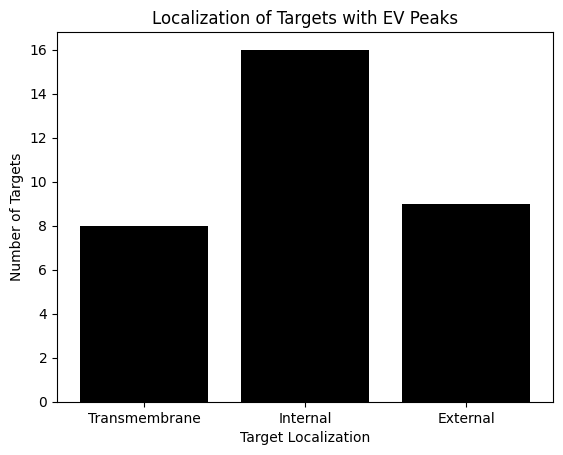

In [609]:
tm_peak = set(tm_targets) & set(correct_fractionation)
internal_peak = set(internal_targets) & set(correct_fractionation)
external_peak = set(external_targets) & set(correct_fractionation)

peak_dict = {
    "Transmembrane": len(tm_peak),
    "Internal": len(internal_peak),
    "External": len(external_peak),
}

x_labels = list(peak_dict.keys())
y_labels = list(peak_dict.values())

plt.bar(x_labels, y_labels, color="black")
plt.xlabel("Target Localization")
plt.ylabel("Number of Targets")
plt.title("Localization of Targets with EV Peaks")
plt.show()

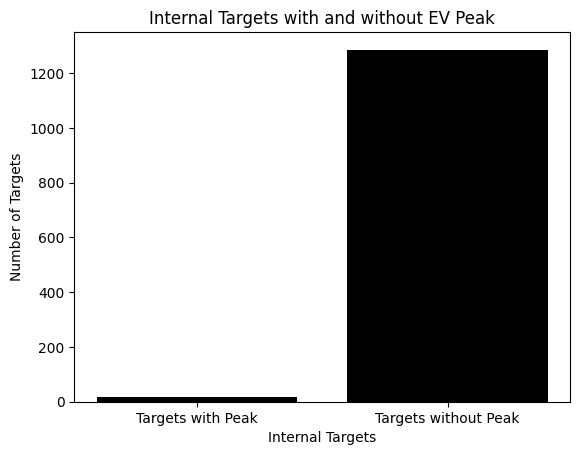

In [610]:
internal_with_peak = set(internal_targets) & set(correct_fractionation)
internal_without_peak = set(internal_targets) - set(correct_fractionation)

int_dict = {
    "Targets with Peak": len(internal_with_peak),
    "Targets without Peak": len(internal_without_peak),
}

x_labels = list(int_dict.keys())
y_labels = list(int_dict.values())

plt.bar(x_labels, y_labels, color="black")
plt.xlabel("Internal Targets")
plt.ylabel("Number of Targets")
plt.title("Internal Targets with and without EV Peak")
plt.show()

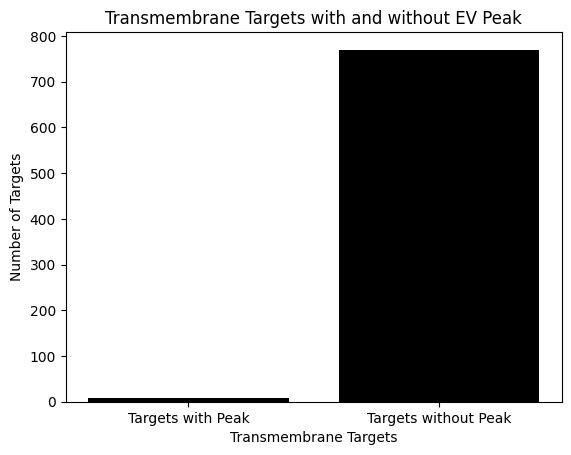

In [611]:
tm_with_peak = set(tm_targets) & set(correct_fractionation)
tm_without_peak = set(tm_targets) - set(correct_fractionation)

tm_dict = {
    "Targets with Peak": len(tm_with_peak),
    "Targets without Peak": len(tm_without_peak),
}

x_labels = list(tm_dict.keys())
y_labels = list(tm_dict.values())

plt.bar(x_labels, y_labels, color="black")
plt.xlabel("Transmembrane Targets")
plt.ylabel("Number of Targets")
plt.title("Transmembrane Targets with and without EV Peak")
plt.show()

In [612]:
# Overlap between median assays, brain rna seq, and transmembrane targets

# TM microglia
tm_microglia_targets = (
    set(correct_fractionation) & set(microglia_uniprot_ids) & set(tm_targets)
)

# TM astrocyte
tm_astrocyte_targets = (
    set(correct_fractionation) & set(astrocyte_uniprot_ids) & set(tm_targets)
)

# TM oligodendrocyte
tm_oligodendrocyte_targets = (
    set(correct_fractionation) & set(oligodendrocyte_uniprot_ids) & set(tm_targets)
)

# TM neuron
tm_neuron_targets = (
    set(correct_fractionation) & set(neuron_uniprot_ids) & set(tm_targets)
)

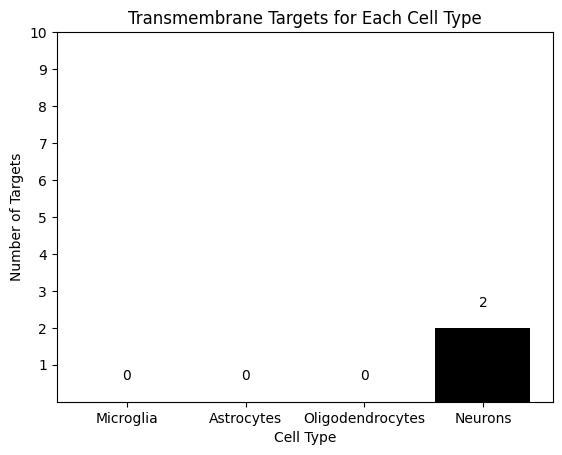

In [613]:
# Number of transmembrane targets per cell type

internal_dict = {
    "Microglia": len(tm_microglia_targets),
    "Astrocytes": len(tm_astrocyte_targets),
    "Oligodendrocytes": len(tm_oligodendrocyte_targets),
    "Neurons": len(tm_neuron_targets),
}

x_labels = list(internal_dict.keys())
y_labels = list(internal_dict.values())

plt.bar(x_labels, y_labels, color="black")

for i, v in enumerate(y_labels):
    plt.text(i, v + 0.5, str(v), ha="center", va="bottom")

plt.yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

plt.xlabel("Cell Type")
plt.ylabel("Number of Targets")
plt.title("Transmembrane Targets for Each Cell Type")
plt.show()

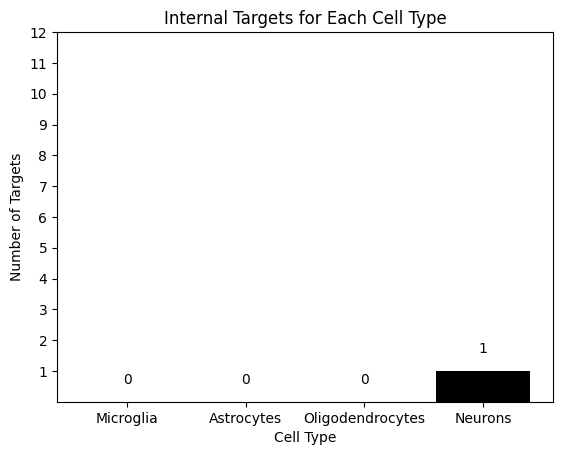

In [614]:
internal_dict = {
    "Microglia": len(internal_microglia_targets),
    "Astrocytes": len(internal_astrocyte_targets),
    "Oligodendrocytes": len(internal_oligodendrocyte_targets),
    "Neurons": len(internal_neuron_targets),
}

x_labels = list(internal_dict.keys())
y_labels = list(internal_dict.values())

plt.bar(x_labels, y_labels, color="black")

for i, v in enumerate(y_labels):
    plt.text(i, v + 0.5, str(v), ha="center", va="bottom")

plt.yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

plt.xlabel("Cell Type")
plt.ylabel("Number of Targets")
plt.title("Internal Targets for Each Cell Type")
plt.show()

In [592]:
CSF_SAMPLES = [
    "SEC Fract 6 ",
    "SEC Fract 7",
    "SEC Fract 8",
    "SEC Fract 9",
    "SEC Fract 10",
    "SEC Fract 11",
    "SEC Fract 12",
    "SEC Fract 13",
    "SEC Fract 14",
    "SEC Fract 15",
    "CSF A Internal EV",
    "CSF B Internal EV",
    "CSF C Internal EV",
    "CSF D Internal EV",
]


def graph_medians(uniprot_id):
    df = tidy_data[uniprot_id]
    df = df.reset_index(level=["SampleID", "Health", "Sample"])

    df["Sample"] = pd.Categorical(df["Sample"], categories=CSF_SAMPLES, ordered=True)

    df_sorted = df.sort_values("Sample")

    grouped_data = [
        group[uniprot_id].values for name, group in df_sorted.groupby("Sample")
    ]

    plt.boxplot(grouped_data, notch=None, vert=None, patch_artist=None, widths=None)

    plt.xlabel("Sample Description")

    plt.ylabel("Delta")

    plt.title(f"{uniprot_id} Fractionation Pattern")

    plt.xticks(range(1, len(CSF_SAMPLES) + 1), CSF_SAMPLES)

    plt.xticks(rotation=45, ha="right")

    plt.show()